In [1]:
from glob import glob
import numpy as np
import scipy as sp
import json
import os
import matplotlib.pyplot as plt
import pandas as pd

os.chdir("../")

from src.detectors import gcc_phat_detector
from src.tdoa_matrix_to_tdoa_vector import tdoa_matrix_to_tdoa_vector

In [8]:

experiment_ensemble_folder = "./data/tdoa_20201016/data/"
experiment_name = "music_0014"
experiment_ensemble_folder = "./data/LuViRA_sound/audio_packaged_with_gt/"
experiment_name = "music3"

input_folder = experiment_ensemble_folder + experiment_name + "/"
gcc_phat_detector(input_folder, window_length=10000, speed_of_movement=1)
detections = np.load(input_folder + "detections.npy")
n_detection_windows = detections.shape[0]
n_mics = detections.shape[1]
tdoa_matrix_to_tdoa_vector(
    input_folder, cutoff_fraction_of_all_measuremnets=1/2)
tdoav = np.load(input_folder + "tdoa_vectors.npy")
df = pd.DataFrame(tdoav)
df.to_csv(input_folder + "tdoa_vector_" + experiment_name + "_to_matlab.csv")


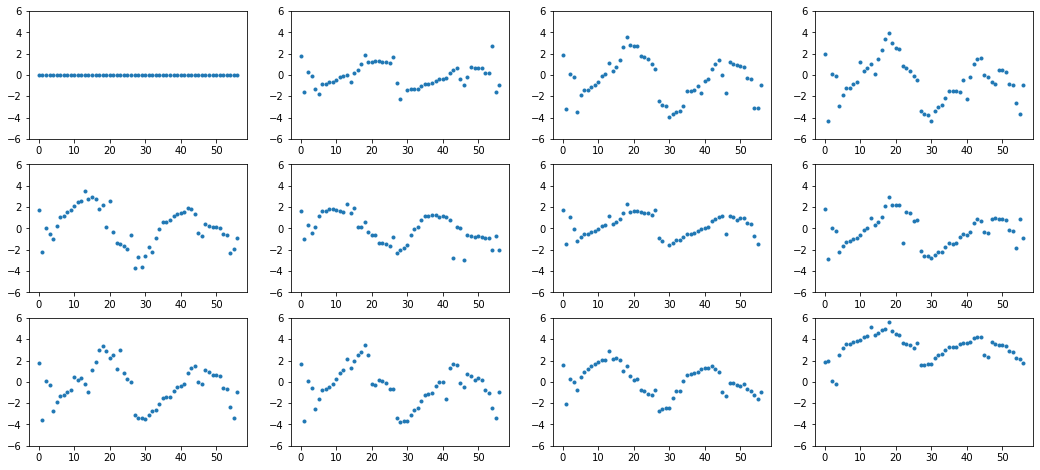

In [9]:
# Example plot
plt.subplots(nrows=3, ncols=4, figsize=(18, 8))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.plot(tdoav[:, i], '.')
    plt.ylim([-6, 6])


In [20]:
# input_folder = "./data/tdoa_20201016/data/music_0012/"
# gcc_phat_detector(input_folder, window_length=30000)
# detections = np.load(input_folder + "detections.npy")


(109, 12)

In [13]:
np.abs(np.array(1 + 1j))


1.4142135623730951